In [1]:
import json

import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 2000)
pd.set_option("mode.chained_assignment", None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 6)})
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_style({'font.family':'Sofia Pro'})
flatui = ["#8B0ABE",  "#4989F5", "#FE2665", "#F28201", "#FFB624" ,"#e74c3c", "#34495e"]  # ,'gold', "deeppink", "#3498db", "#95a5a6",  "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "darkviolet",
sns.set_palette(flatui)

In [2]:
raw_df = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-07-27/olympics.csv")

In [3]:
raw_df.head(2)

,id,name,sex,age,height,weight,team,noc,games,year,season,city,sport,event,medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN


In [4]:
raw_df['medal'].value_counts(dropna=False, normalize=True)

NaN       0.853262
Gold      0.049322
Bronze    0.049038
Silver    0.048378
Name: medal, dtype: float64

In [5]:
raw_df.isna().mean(axis=0)

id        0.000000
name      0.000000
sex       0.000000
age       0.034944
height    0.221938
weight    0.231912
team      0.000000
noc       0.000000
games     0.000000
year      0.000000
season    0.000000
city      0.000000
sport     0.000000
event     0.000000
medal     0.853262
dtype: float64

<AxesSubplot:xlabel='year', ylabel='id'>

findfont: Font family ['Sofia Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Sofia Pro'] not found. Falling back to DejaVu Sans.


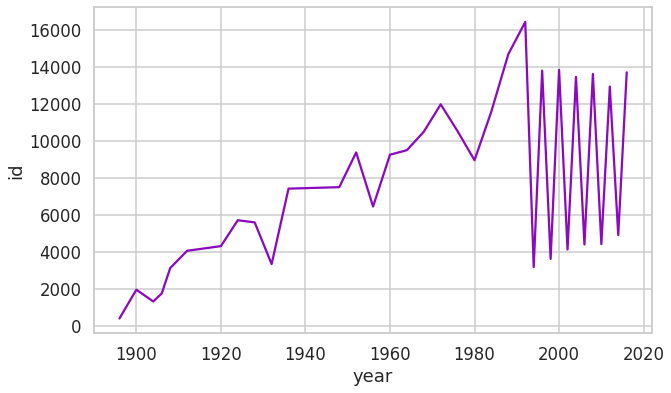

In [6]:
df_to_plot = raw_df.groupby('year', as_index=False)['id'].count().sort_index()
sns.lineplot(data=df_to_plot, x='year', y='id')

<AxesSubplot:xlabel='year', ylabel='id'>

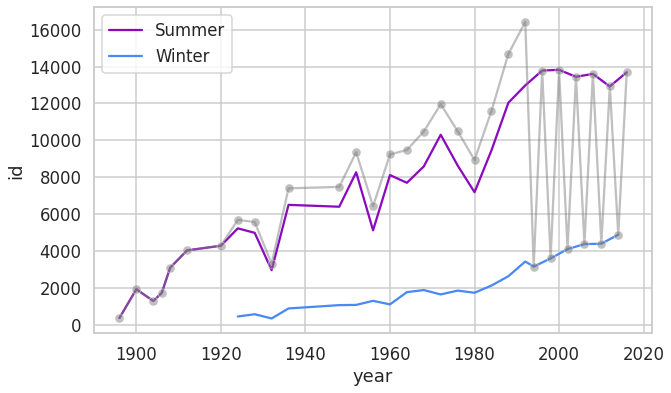

In [7]:
df_to_plot = raw_df.groupby(['year', 'season'], as_index=False)['id'].count().sort_index()
sns.lineplot(data=df_to_plot, x='year', y='id', hue='season')

df_to_plot = raw_df.groupby('year', as_index=False)['id'].count().sort_index()
sns.lineplot(data=df_to_plot, x='year', y='id', color='gray', alpha=0.5, marker='o')

<AxesSubplot:xlabel='year', ylabel='sport'>

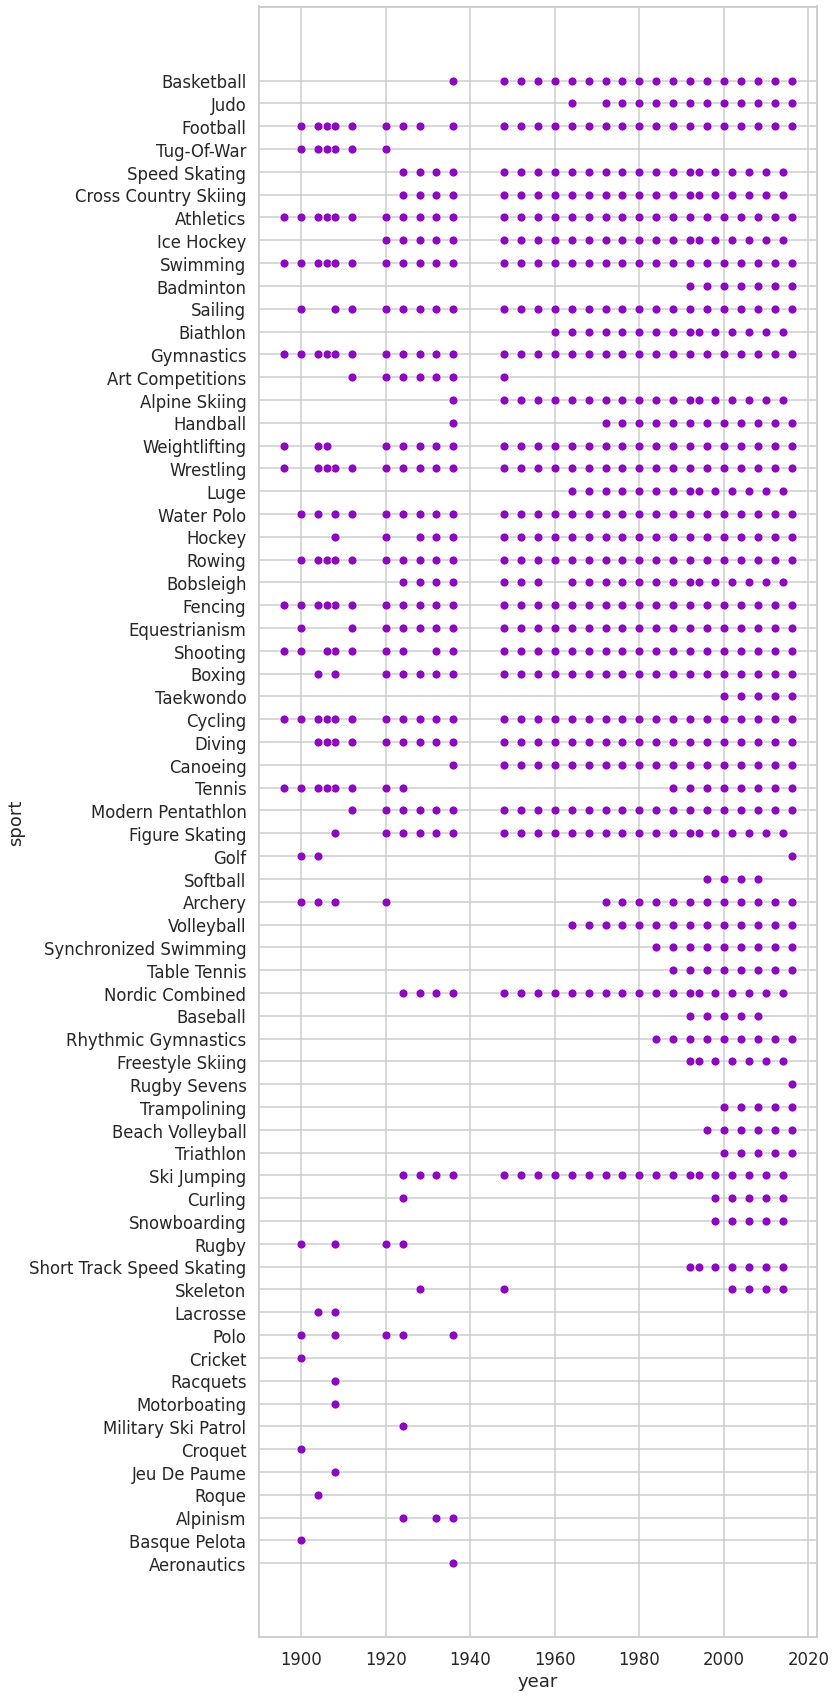

In [8]:
df_to_plot = raw_df.drop_duplicates(['year', 'sport'])

fig, ax = plt.subplots(figsize=(10, 30))

sns.scatterplot(data=df_to_plot, x='year', y='sport')

In [9]:
raw_df['sex'].value_counts(dropna=False, normalize=True)

M    0.725129
F    0.274871
Name: sex, dtype: float64

In [10]:
raw_df[['team', 'noc']]

,team,noc
0,China,CHN
1,China,CHN
2,Denmark,DEN
3,Denmark/Sweden,DEN
4,Netherlands,NED
...,...,...
271111,Poland-1,POL
271112,Poland,POL
271113,Poland,POL
271114,Poland,POL


In [11]:
noc_to_team = (
    raw_df.groupby(['team', 'noc'], as_index=False)['id']
    .count()
    .rename(columns={'id': 'count'})
    .sort_values('count', ascending=False)
    .groupby('noc')
    ['team']
    .first()
)

raw_df['team_norm'] = raw_df['noc'].map(noc_to_team)
raw_df[['team', 'noc', 'team_norm']]

,team,noc,team_norm
0,China,CHN,China
1,China,CHN,China
2,Denmark,DEN,Denmark
3,Denmark/Sweden,DEN,Denmark
4,Netherlands,NED,Netherlands
...,...,...,...
271111,Poland-1,POL,Poland
271112,Poland,POL,Poland
271113,Poland,POL,Poland
271114,Poland,POL,Poland


In [12]:
df_to_plot = raw_df.groupby(['team_norm']).agg(
    count=('sex', len),
    mean_sex=('sex',  lambda sex: np.mean(sex == 'M'))
).reset_index()


def calc_ci(mu, count, z=1.645):
    return z*np.sqrt((mu * (1 - mu)) / count)

df_to_plot['upper_ci'] = df_to_plot.apply(lambda x: x['mean_sex'] + calc_ci(x['mean_sex'], x['count']), axis=1)
df_to_plot['lower_ci'] = df_to_plot.apply(lambda x: x['mean_sex'] - calc_ci(x['mean_sex'], x['count']), axis=1)

df_to_plot.head(2)

,team_norm,count,mean_sex,upper_ci,lower_ci
0,Afghanistan,126,0.960317,0.988925,0.931709
1,Albania,70,0.614286,0.709991,0.518581


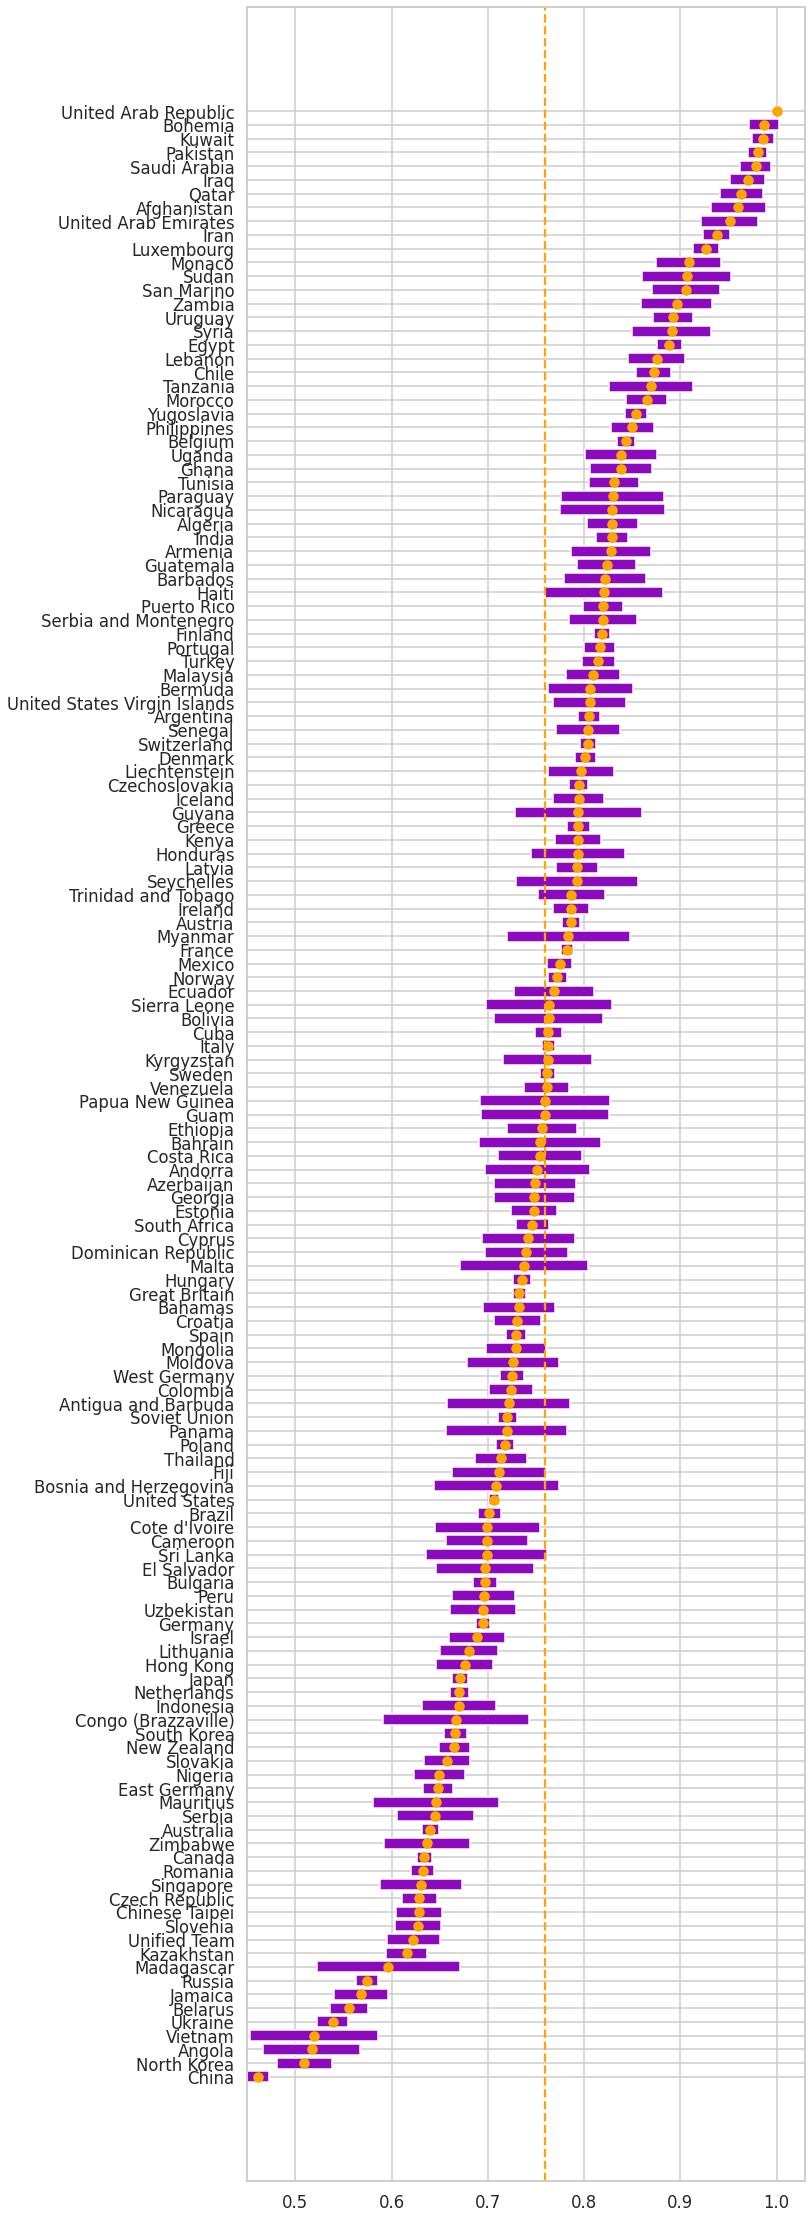

In [13]:
df_to_plot.sort_values(by='mean_sex', inplace=True)

df_to_plot = df_to_plot[df_to_plot['count'] >= 100]

fig, ax = plt.subplots(figsize=(10, 40))

plt.barh(y=df_to_plot['team_norm'], 
         width=df_to_plot['upper_ci'] - df_to_plot['lower_ci'], 
         left=df_to_plot['lower_ci'])

plt.scatter(df_to_plot['mean_sex'], df_to_plot['team_norm'], color='orange', zorder=999)

plt.axvline(df_to_plot['mean_sex'].mean(), linestyle='--', color='orange')

plt.show()

In [14]:
df_to_plot[df_to_plot['team_norm'] == 'Israel']

,team_norm,count,mean_sex,upper_ci,lower_ci
97,Israel,665,0.688722,0.718258,0.659186


In [15]:
df_to_plot = raw_df[(raw_df['year'].between(2000, 2020))
                   & (raw_df['medal'].notna())]

df_to_plot['total_medals_in_team'] = df_to_plot.groupby(['team_norm'])['id'].transform(len)
df_to_plot['total_medals_in_sport'] = df_to_plot.groupby(['sport'])['id'].transform(len)

df_to_plot = (df_to_plot.groupby(['team_norm', 'sport'], as_index=False).apply(lambda x: pd.Series({
    'medals_within_team': len(x['id']) / x['total_medals_in_team'].max(),
    'medals_within_sport': len(x['id']) / x['total_medals_in_sport'].max(),
}))
             )

In [16]:
df_to_plot.head(2)

,team_norm,sport,medals_within_team,medals_within_sport
0,Afghanistan,Taekwondo,1.0,0.013889
1,Algeria,Athletics,0.7,0.007455


/Users/shuki/.pyenv/versions/3.7.0/envs/ai21-analytics/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='medals_within_team', ylabel='medals_within_sport'>

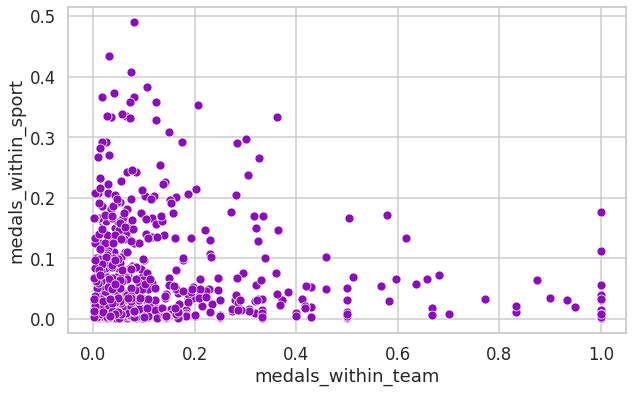

In [17]:
sns.scatterplot(df_to_plot['medals_within_team'], df_to_plot['medals_within_sport'])

In [ ]:
import mpld3
from mpld3 import plugins
import ipywidgets

@ipywidgets.interact(
    team=ipywidgets.Dropdown(options=[None] + sorted(df_to_plot['team_norm'].unique())),
    sport=ipywidgets.Dropdown(options=[None] + sorted(df_to_plot['sport'].unique()))
)
def show_the_big_picture(team, sport):
    if (team is None) == (sport is None):
        print('Please choose either team or sport!')
        return
    
    fig, ax = plt.subplots()

    df_filtered = df_to_plot[
        (df_to_plot['team_norm'] == team) if team is not None
        else (df_to_plot['sport'] == sport)
    ]

    points = ax.plot(df_filtered['medals_within_team'], df_filtered['medals_within_sport'], 'o', color='b',
                     mec='k', ms=15, mew=1, alpha=.6)

    tooltip = plugins.PointHTMLTooltip(points[0], list(df_filtered['team_norm'] + ', ' + df_filtered['sport']))
    plugins.connect(fig, tooltip)

    return mpld3.display()